Copyright ©  2021  MIT License | Sapozhnikov Andrey Mikhailovich  
* * *
**Tacotron2 + TP-GST + BERT**  
this notebook shows train and inference usage of realization  
[Text-predicting Global Style Tokens for Tacotron2](https://arxiv.org/pdf/1808.01410.pdf) with [BERT](https://m.habr.com/ru/company/sberdevices/blog/548812/)  

**Model repository**: https://github.com/lightbooster/mellotron/tree/tp-gst-bert

# Tacotron2 TP-GST

## Prepair for training

Mount Google Drive to store all checkpoints and datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download Dataset

Download M-AILABS Russian dataset

In [ ]:
# %cd /content/drive/MyDrive/
# !wget http://www.caito.de/data/Training/stt_tts/ru_RU.tgz
# !tar -zxvf ru_RU.tgz
# # Rename directory
# !mv ru_RU M_AILABS_Ru

### Preprocess Dataset


In [ ]:
import random

In [ ]:
"""
Move all wav file to the common folder
Concat all text files into one
"""
def refactor_M_AILABS(sex='female', speaker_index=0
                      , dataset_dir="/content/drive/MyDrive/M_AILABS_Ru/"
                      , out_dir="/content/drive/MyDrive/M_AILABS_Ru/"
                      , move_files=True
                      ):
  print(" *** Start refactoring... ***")
  path = f"{dataset_dit}{''if dataset_dit[-1] == '/' else '/'}by_book/{sex}"
  %cd $path
  speakers = !ls
  books_path = f"{path}/{speakers[speaker_index]}"
  %cd $books_path
  books_folders = !ls -d */ | cut -f1 -d'/'
  path = f"{out_dir}{''if out_dir[-1] == '/' else '/'}"
  %cd $path
  !mkdir wavs
  wavs_path = f"{path}wavs/"
  !touch mlbs_audio_text.txt
  for book in books_folders:
    cur_wavs_path = f"{books_path}/{book}/wavs/*"
    cur_text_path = f"{books_path}/{book}/metadata.csv"
    !cat $cur_text_path >> mlbs_audio_text.txt
    if move_files:
      !mv -v $cur_wavs_path $wavs_path
  print(" *** Refactoring finished! ***")

In [ ]:
# refactor_M_AILABS()

In [ ]:
"""
M-Ailabs dataset has 2 strings of audio trascription -
raw and normalized
This function chooose one, based on argument 
and add wav file full path
"""
def transform_m_ailabs_text(file_name="mlbs_audio_text.txt",
                            new_file_name="mlbs_audio_text_transformed.txt",
                            dataset_dir="/content/drive/MyDrive/M_AILABS_Ru/",
                            raw_data=False):
  write_file = open(dataset_dir+new_file_name, 'w', encoding='utf-8')
  with open(dataset_dir+file_name, 'r', encoding='utf-8') as read_file:
    for line in read_file:
      line = line.split('|')
      wav_file_path = f"{dataset_dir}wavs/{line[0]}.wav"
      new_line = f"{wav_file_path}|{line[1] if raw_data else line[2]}"
      write_file.write(new_line)

In [ ]:
# transform_m_ailabs_text()

In [ ]:
"""
We should split data into 3 sets:
'train', 'test' and 'eval'
"""
def split_dataset(test_size=0.05, eval_size=0.01,
                  dataset_dir="/content/drive/MyDrive/M_AILABS_Ru/",
                  source_file_name="mlbs_audio_text_transformed.txt",
                  output_file_name_base="mlbs_audio_text",
                  shuffle=True):
  if test_size + eval_size >= 1:
    print("ERROR: (test_size + eval_size) must be less 1")
    return
  
  data = []
  with open(f"{dataset_dir}{source_file_name}",
            'r', encoding='utf-8') as read_file:
    for line in read_file:
      data.append(line)
  
  length = len(data)
  test_length = int(length * test_size)
  eval_length = int(length * eval_size)
  if shuffle:
    random.shuffle(data)
  test_data = data[: test_length]
  eval_data = data[test_length : test_length + eval_length]
  train_data = data[test_length + eval_length :]

  sets = {'test': test_data, 'eval': eval_data, 'train': train_data}
  for name, dataset in sets.items():
    with open(f"{dataset_dir}{output_file_name_base}_{name}.txt", 
              'w', encoding='utf-8') as file:
      for line in dataset:
        file.write(line)


In [ ]:
# split_dataset(shuffle=False)

### Install libs

Download BERT checkpoint

In [ ]:
# !wget http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz
# !tar -xvzf rubert_cased_L-12_H-768_A-12_pt.tar.gz
# %cd rubert_cased_L-12_H-768_A-12_pt/
# !mv bert_config.json config.json

Clone the repository

In [3]:
%cd /content/
!git clone https://github.com/lightbooster/mellotron.git
%cd mellotron
!git checkout tp-gst-bert

/content
Cloning into 'mellotron'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 209 (delta 29), reused 40 (delta 19), pack-reused 155
Receiving objects: 100% (209/209), 3.97 MiB | 23.09 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/mellotron
Branch 'tp-gst-bert' set up to track remote branch 'tp-gst-bert' from 'origin'.
Switched to a new branch 'tp-gst-bert'


In [4]:
%cd /content/mellotron/

/content/mellotron


In [5]:
!git submodule init; git submodule update

Submodule 'waveglow' (https://github.com/NVIDIA/waveglow.git) registered for path 'waveglow'
Cloning into '/content/mellotron/waveglow'...
Submodule path 'waveglow': checked out '2fd4e63e2918012f55eac2c8a8e75622a39741be'


In [6]:
!cat requirements.txt

matplotlib==2.1.0
tensorflow==1.15.2
inflect==0.2.5
librosa==0.6.0
scipy==1.0.0
tensorboardX==1.1
Unidecode==1.0.22
pillow
nltk==3.4.5
jamo==0.4.1
music21
transformers==4.6.1

In [7]:
!pip install apex
!pip install Unidecode
!pip install tensorflow==1.15.2
!pip install transformers==4.6.1
!pip install tensorboardX

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 716kB 14.9MB/s 
     |████████████████████████████████| 256kB 48.8MB/s 
     |████████████████████████████████| 174kB 47.3MB/s 
     |████████████████████████████████| 256kB 47.7MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 143kB 49.1MB/s 
     |████████████████████████████████| 122kB 52.1MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
  Created wheel for cryptacular: filename=cryptacular-1.5.5-cp37-abi3-manylinux2010_x86_64.whl size=48279 sha256=0ba7a5685a5e31185e5226348e66d6ad56f559b674bfcec99827d607be318bba
  Stored in directory: /root/.cache/pip/wheels/3c/79/bc/1eec7120c3ff9b0a2c7ad94d1626abc3388688e2ed7a45878f
Successfully built cryptacular
  Created wheel for apex: filename=apex-0.9.10.dev0-cp37-none-any.whl size=46468 sha256=830267fdbe768fe1ca79b78fa0

## Train

In [8]:
%cd /content/mellotron/

/content/mellotron


### Hyperparams

In [9]:
home_dir = "/content/drive/MyDrive/"

training_files = home_dir + "M_AILABS_Ru/mlbs_audio_text_train.txt"
validation_files = home_dir + "M_AILABS_Ru/mlbs_audio_text_eval.txt"

output_directory = home_dir + "M_AILABS_Ru/checkpoints_GST_warm"
log_directory = "../logs_GST_warm"

batch_size = 16
iters_per_checkpoint = 1000
sampling_rate = 16000

bert_path = home_dir + "ModelsCheckpoints/rubert_cased_L-12_H-768_A-12_pt/"

hparams = f"batch_size={batch_size},\
            iters_per_checkpoint={iters_per_checkpoint},\
            training_files={training_files},\
            validation_files={validation_files},\
            sampling_rate={sampling_rate},\
            bert_checkpoint_path={bert_path}"

hparams

'batch_size=16,            iters_per_checkpoint=1000,            training_files=/content/drive/MyDrive/M_AILABS_Ru/mlbs_audio_text_train.txt,            validation_files=/content/drive/MyDrive/M_AILABS_Ru/mlbs_audio_text_eval.txt,            sampling_rate=16000,            bert_checkpoint_path=/content/drive/MyDrive/ModelsCheckpoints/rubert_cased_L-12_H-768_A-12_pt/'

### Pretrained weights

NVIDEA checkpoint and deleted language weights

In [ ]:
# checkpoint_path = "/content/drive/MyDrive/ModelsCheckpoints/tacotron2tp-sgt_warm_checkpoint.pt"
# !python train.py --output_directory=$output_directory --log_directory=$log_directory --hparams "$hparams" -c $checkpoint_path --warm_start

my checkpoint and saved weights

In [ ]:
checkpoint_num = 27000
checkpoint_path = f"{output_directory}/checkpoint_{checkpoint_num}"
!python train.py --output_directory=$output_directory --log_directory=$log_directory --hparams "$hparams" -c $checkpoint_path

### From the start

In [ ]:
# !python train.py --output_directory=$output_directory --log_directory=$log_directory --hparams "$hparams"

## Eval

### Tacotron2 + TP-GST + BERT

In [10]:
%cd /content/mellotron/

/content/mellotron


In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')

from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import pandas as pd
import librosa
import torch

from hparams import create_hparams
from model import Tacotron2, load_model
from layers import TacotronSTFT
from data_utils import TextMelLoader, TextMelCollate
from text import cmudict, text_to_sequence
from mellotron_utils import get_data_from_musicxml

In [12]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [13]:
checkpoint_dir = "../drive/MyDrive/M_AILABS_Ru/checkpoints_GST_warm/"
checkpoint_name = "checkpoint_"
checkpoint_num = 27000
checkpoint_path = checkpoint_dir + checkpoint_name + str(checkpoint_num)
checkpoint_path

'../drive/MyDrive/M_AILABS_Ru/checkpoints_GST_warm/checkpoint_27000'

In [14]:
hparams = create_hparams()
hparams.sampling_rate = 16000
hparams.bert_checkpoint_path = bert_path = home_dir + "ModelsCheckpoints/rubert_cased_L-12_H-768_A-12_pt/"
# hparams.gate_threshold = 0.5

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [15]:
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'], strict=False)
_ = model.cuda().eval()

BERT


Some weights of the model checkpoint at /content/drive/MyDrive/ModelsCheckpoints/rubert_cased_L-12_H-768_A-12_pt/ were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert from checkpoint
---------------------


### WaveGlow

In [16]:
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow', pretrained=False)
checkpoint = torch.hub.load_state_dict_from_url('https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ckpt_fp32/versions/19.09.0/files/nvidia_waveglowpyt_fp32_20190427')

# # Unwrap the DistributedDataParallel module
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

# # Apply the state dict to the model
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
_ = waveglow.eval()

Downloading: "https://github.com/nvidia/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1940.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ckpt_fp32/versions/19.09.0/files/nvidia_waveglowpyt_fp32_20190427" to /root/.cache/torch/hub/checkpoints/nvidia_waveglowpyt_fp32_20190427


## Testing

### Inference

In [27]:
text = "Не подскажите какой сегодня день?"

In [28]:
# preprocessing
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.from_numpy(sequence).to(device='cuda', dtype=torch.int64)
sequence

tensor([[ 88,  79,   8,  90,  89,  78,  93,  85,  75, 100,  82,  83,  94,  79,
           8,  85,  75,  85,  89,  83,   8,  93,  79,  81,  89,  78,  88,  83,
          75,   8,  78,  79,  88,   1,   7]], device='cuda:0')

In [35]:
# run the models
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference((sequence, text), 'tpse-linear')
    audio = waveglow.infer(mel_outputs_postnet)
audio_numpy = audio[0].data.cpu().numpy()
rate = 16000
mel_outputs.shape

torch.Size([1, 80, 208])

Reference audio

In [ ]:
import librosa

In [ ]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

def load_mel(path):
    audio, sampling_rate = librosa.core.load(path, sr=16000)
    audio = torch.from_numpy(audio)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec

In [ ]:
reference_mel = load_mel('/content/drive/MyDrive/M_AILABS_Ru/wavs/chetvero_nischih_s000001.wav')
reference_mel.shape

torch.Size([1, 80, 639])

In [ ]:
# run the models
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference_reference((sequence, reference_mel))
    audio = waveglow.infer(mel_outputs_postnet)
audio_numpy = audio[0].data.cpu().numpy()
rate = 16000
mel_outputs.shape

Warning! Reached max decoder steps


torch.Size([1, 80, 1000])

Visualize Mels

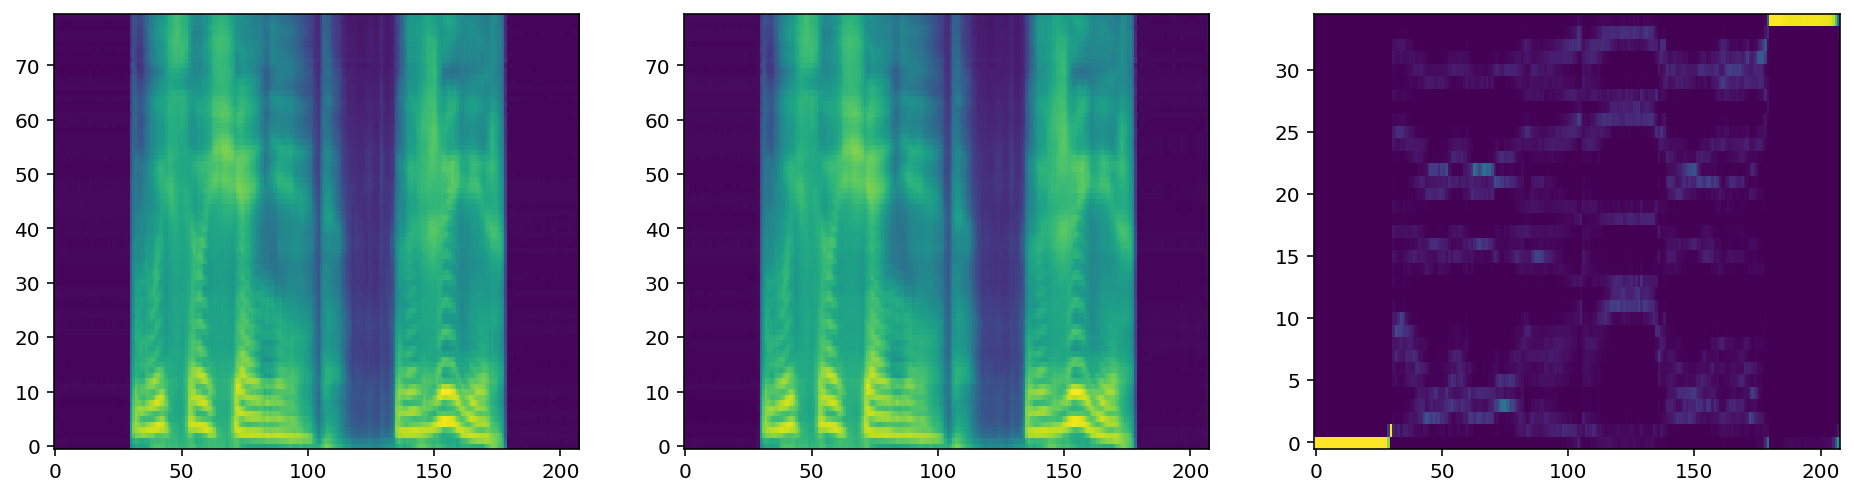

In [36]:
%matplotlib inline
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))
plt.show()

### Audio

In [38]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22500
ipd.Audio(audio_numpy, rate=rate)